In [1]:
# results_df = pd.DataFrame([result.dict() for result in results])
# results_df.to_csv(f"{OUTPUT_DIR}/phishing_analysis_results.csv", index=False)

# class PhishingAnalysisResult(BaseModel):
#     email_id: str
#     model_name: str
#     ground_truth_is_phishing: bool
#     ground_truth_content: str
#     predicted_is_phishing: bool
#     prompt_technique: str
#     result_file: str
#     timestamp: str

import pandas as pd
import os
# Load the results from the CSV file
results_df = pd.read_csv("phishing_experiment_results/phishing_analysis_results.csv")
print(f"Loaded {len(results_df)} phishing analysis results from CSV.")



Loaded 60 phishing analysis results from CSV.


Overall accuracy: 0.62

Accuracy by model:
model_name
mistral:7b    0.80
llama3:8b     0.55
gemma:7b      0.50
dtype: float64

Accuracy by prompt technique:
prompt_technique
AUTOMATE            0.666667
Chain-of-Thought    0.666667
Few-Shot            0.666667
Multi-Prompt        0.583333
Two-Step            0.500000
dtype: float64

Top 5 model-technique combinations by accuracy:
        model         technique  accuracy  precision  recall   f1
6  mistral:7b          Few-Shot      1.00   1.000000     1.0  1.0
5  mistral:7b          AUTOMATE      1.00   1.000000     1.0  1.0
2   llama3:8b  Chain-of-Thought      0.75   0.666667     1.0  0.8
8  mistral:7b      Multi-Prompt      0.75   0.666667     1.0  0.8
7  mistral:7b  Chain-of-Thought      0.75   0.666667     1.0  0.8


/tmp/ipykernel_51147/3616689411.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_accuracy = results_df.groupby('model_name').apply(
/tmp/ipykernel_51147/3616689411.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  technique_accuracy = results_df.groupby('prompt_technique').apply(


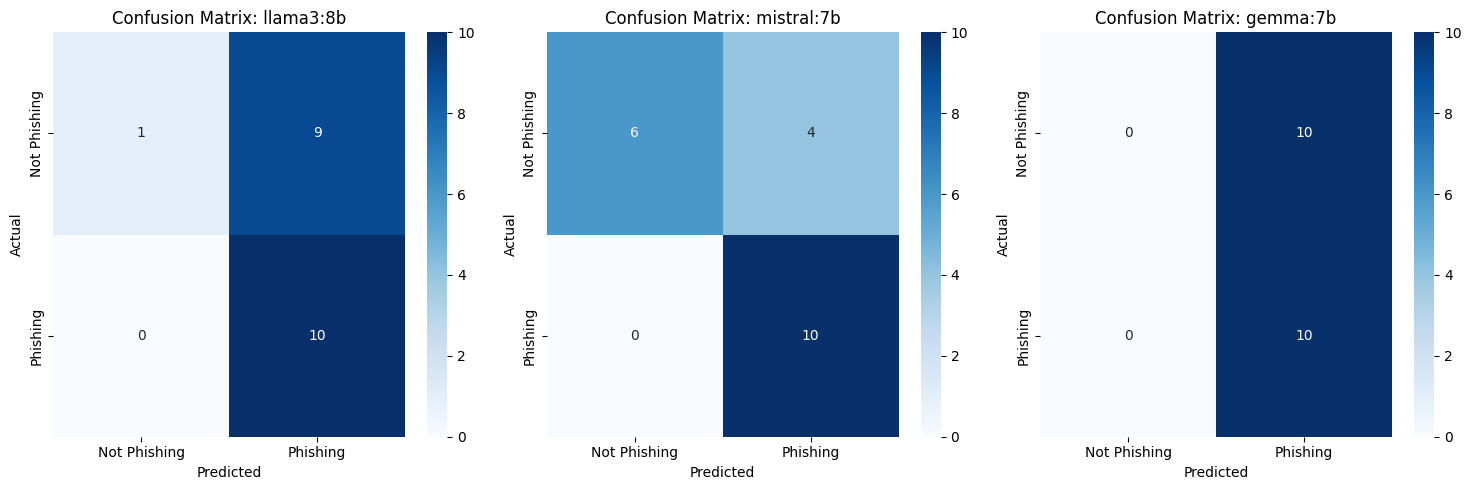

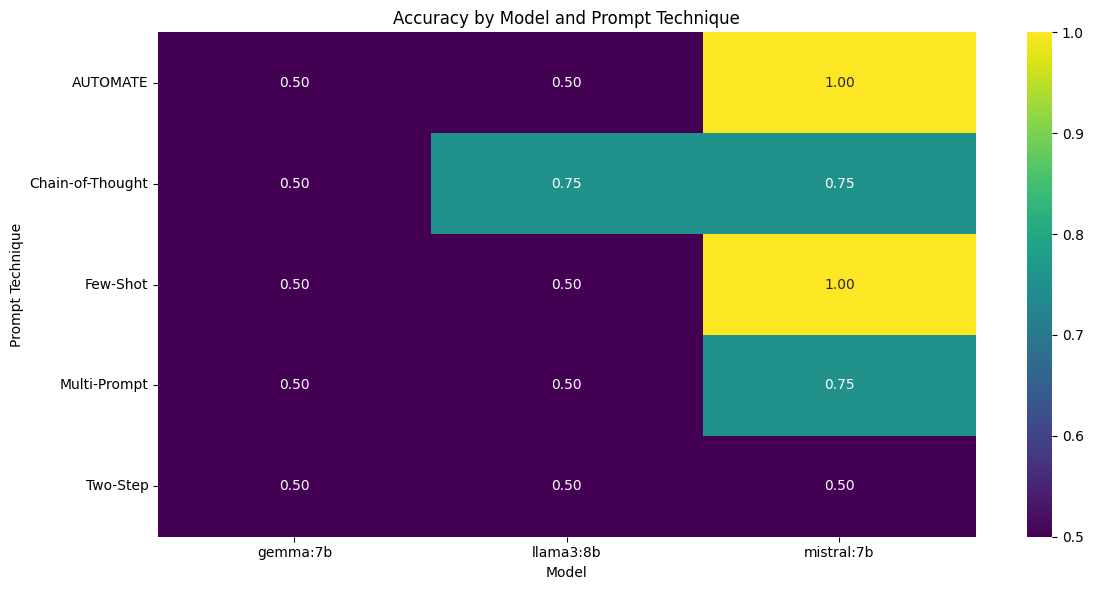

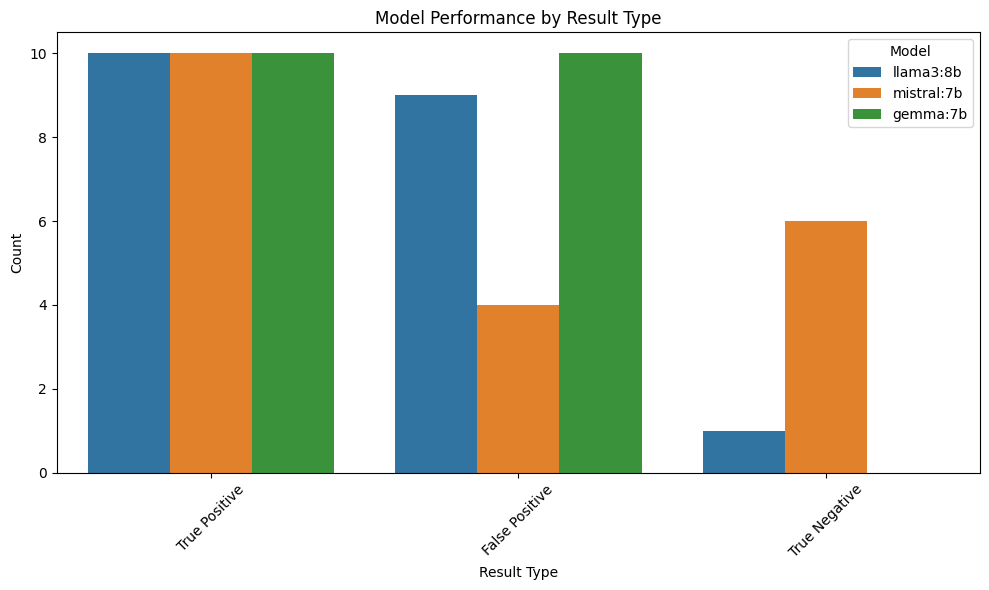

In [2]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

# Calculate overall accuracy
overall_accuracy = (results_df['predicted_is_phishing'] == results_df['ground_truth_is_phishing']).mean()
print(f"Overall accuracy: {overall_accuracy:.2f}")

# Calculate accuracy by model
model_accuracy = results_df.groupby('model_name').apply(
    lambda x: (x['predicted_is_phishing'] == x['ground_truth_is_phishing']).mean()
).sort_values(ascending=False)
print("\nAccuracy by model:")
print(model_accuracy)

# Calculate accuracy by prompt technique
technique_accuracy = results_df.groupby('prompt_technique').apply(
    lambda x: (x['predicted_is_phishing'] == x['ground_truth_is_phishing']).mean()
).sort_values(ascending=False)
print("\nAccuracy by prompt technique:")
print(technique_accuracy)

# Calculate metrics for each model and technique
metrics = []
for model in results_df['model_name'].unique():
    for technique in results_df['prompt_technique'].unique():
        subset = results_df[(results_df['model_name'] == model) & 
                           (results_df['prompt_technique'] == technique)]
        if len(subset) > 0:
            y_true = subset['ground_truth_is_phishing']
            y_pred = subset['predicted_is_phishing']
            metrics.append({
                'model': model,
                'technique': technique,
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, zero_division=0),
                'recall': recall_score(y_true, y_pred, zero_division=0),
                'f1': f1_score(y_true, y_pred, zero_division=0)
            })

metrics_df = pd.DataFrame(metrics)
print("\nTop 5 model-technique combinations by accuracy:")
print(metrics_df.sort_values('accuracy', ascending=False).head())

# Confusion matrix for each model
plt.figure(figsize=(15, 5))
for i, model in enumerate(results_df['model_name'].unique()):
    plt.subplot(1, 3, i+1)
    model_data = results_df[results_df['model_name'] == model]
    cm = confusion_matrix(model_data['ground_truth_is_phishing'], 
                          model_data['predicted_is_phishing'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Phishing', 'Phishing'],
                yticklabels=['Not Phishing', 'Phishing'])
    plt.title(f'Confusion Matrix: {model}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Visualization of accuracy by technique across models
plt.figure(figsize=(12, 6))
pivot_table = metrics_df.pivot(index='technique', columns='model', values='accuracy')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.2f')
plt.title('Accuracy by Model and Prompt Technique')
plt.ylabel('Prompt Technique')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# Analysis of true/false positives and negatives
results_df['correct'] = results_df['predicted_is_phishing'] == results_df['ground_truth_is_phishing']
results_df['result_type'] = results_df.apply(
    lambda x: 'True Positive' if x['ground_truth_is_phishing'] and x['predicted_is_phishing'] else
              'True Negative' if not x['ground_truth_is_phishing'] and not x['predicted_is_phishing'] else
              'False Positive' if not x['ground_truth_is_phishing'] and x['predicted_is_phishing'] else
              'False Negative', axis=1)

result_count = results_df['result_type'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(data=results_df, x='result_type', hue='model_name')
plt.title('Model Performance by Result Type')
plt.xlabel('Result Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()
